
================================================================================
LINE P TIMESERIES ANALYSIS - SEASONAL CYCLE FITTING WITH GAUSSIAN PROCESSES
================================================================================

This notebook demonstrates how to:
1. Load preprocessed timeseries data from netCDF files
2. Fit a model with seasonal cycle + linear trend using basis functions
3. Estimate uncertainties in the fitted parameters
4. Generate multiple realizations to visualize parameter uncertainty

Original MATLAB code by: Ana C. Franco (ana.franco@bsc.es)
Python adaptation for Line P Hackathon - Dec 2025

Key References:
- fitrgp: Gaussian Process Regression (MATLAB equivalent: sklearn GaussianProcessRegressor)
- Basis functions: constant + linear trend + seasonal (cos/sin)
- Parameter covariance: used to propagate uncertainties through the model

================================================================================
"""

In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ============================================================================
# === Initialize ===
# ============================================================================

# User defined parameters
file_path = '/gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/SD-Ocean/observations_LineP/interpolated/'
major_st = 26
var2plot = 'DIC_UMOL_KG'
plot_timeseries = True
layers = [10]  # Can extend to [10, 20, 30, ..., 200]

# ============================================================================
# === Helper Functions ===
# ============================================================================

def basis_function(t):
    """
    WHAT DOES THIS DO?
    ------------------
    Creates the basis functions for our model. We're fitting:

        y(t) = β₀·1 + β₁·t + β₂·cos(2πt/365.25) + β₃·sin(2πt/365.25)

    where:
    - β₀: intercept (constant mean value)
    - β₁: linear trend (change per day)
    - β₂, β₃: seasonal cycle parameters (combined into amplitude & phase)

    MATHEMATICAL BACKGROUND:
    - The cos/sin terms have period = 365.25 days (1 year)
    - Using both cos and sin allows us to fit any phase shift
    - β₂² + β₃² = amplitude of seasonal cycle

    INPUTS:
    -------
    t : array-like
        Time values in days since epoch (MATLAB datenum format)

    OUTPUTS:
    --------
    H : ndarray, shape (n_samples, 4)
        Design matrix where each column is a basis function evaluated at time t
        - Column 0: ones (for β₀)
        - Column 1: t values (for β₁)
        - Column 2: cosine term (for β₂)
        - Column 3: sine term (for β₃)

    EXAMPLE:
    --------
    If t = [0, 100, 200], then:
    H[0, :] = [1, 0, 1, 0]
    H[1, :] = [1, 100, cos(...), sin(...)]
    H[2, :] = [1, 200, cos(...), sin(...)]
    """
    t = np.asarray(t).flatten()
    ones = np.ones_like(t)
    cos_term = np.cos(2 * np.pi * t / 365.25)
    sin_term = np.sin(2 * np.pi * t / 365.25)
    return np.column_stack([ones, t, cos_term, sin_term])


def datenum_to_days(dates):
    """
    WHAT DOES THIS DO?
    ------------------
    Converts datetime objects to days since epoch (similar to MATLAB's datenum).
    This gives us a continuous numeric representation of time that's easy to work with.

    INPUTS:
    -------
    dates : array-like
        datetime64 or datetime objects

    OUTPUTS:
    --------
    array : ndarray
        Days since 1970-01-01 (Unix epoch)

    EXAMPLE:
    --------
    datenum_to_days(['2020-01-01', '2020-01-02']) → [18262, 18263]
    """
    dates = pd.to_datetime(dates)
    epoch = pd.Timestamp("1970-01-01")
    return (dates - epoch).days.values


def days_to_datenum(days):
    """
    WHAT DOES THIS DO?
    ------------------
    Inverse of datenum_to_days. Converts numeric days back to dates.
    """
    epoch = pd.Timestamp("1970-01-01")
    return epoch + pd.to_timedelta(days, unit='D')

# ============================================================================
# === Process each layer ===
# ============================================================================

In [ ]:


"""
================================================================================
PART 3: MAIN PROCESSING LOOP - COMPLETE ANNOTATED VERSION
================================================================================

This section processes each depth layer through the complete analysis pipeline:
1. Load and clean data
2. Build design matrix
3. Fit parameters using least-squares
4. Estimate uncertainties
5. Generate posterior samples
6. Store results

Expected output: results dictionary with all fitted parameters and statistics
"""

print("\n" + "="*80)
print("PART 3: MAIN PROCESSING LOOP - LEAST-SQUARES FIT & UNCERTAINTY ESTIMATION")
print("="*80)


# Initialize results dictionary to store all outputs
results = {}

# ============================================================================
# LOOP OVER EACH DEPTH LAYER
# ============================================================================

for layer_idx, depth in enumerate(layers):
    print(f"\n{'='*60}")
    print(f"LAYER {layer_idx + 1}/{len(layers)}: Processing depth {depth}m")
    print(f"{'='*60}")

    # ========================================================================
    # STEP 1: LOAD AND PREPROCESS DATA
    # ========================================================================

    print(f"\n[STEP 1] Loading and preprocessing data...")

    # Construct the filename based on variable name and depth
    ncfile = f'{file_path}/LineP_{var2plot}_timeseries_1990_2019_{depth}m.nc'

    # Attempt to load the file
    try:
        ds = xr.open_dataset(ncfile)
        print(f"  ✓ Successfully loaded: {ncfile}")
    except FileNotFoundError:
        print(f"  ✗ File not found: {ncfile}")
        print(f"    Skipping depth {depth}m...")
        continue

    # Extract the measurement variable and time components
    ydata_tmp = ds['INTERP_VAR_mean'].values      # Raw observations
    year_tmp = ds['YEAR_UTC'].values
    month_tmp = ds['MONTH_UTC'].values
    day_tmp = ds['DAY_UTC'].values

    print(f"    Raw measurements: {len(ydata_tmp)} points")
    print(f"    Date range: {year_tmp[0]}-{month_tmp[0]}-{day_tmp[0]} to "
          f"{year_tmp[-1]}-{month_tmp[-1]}-{day_tmp[-1]}")

    # Create datetime objects from year/month/day components
    dates_tmp = pd.to_datetime(
        pd.DataFrame({
            'year': year_tmp,
            'month': month_tmp,
            'day': day_tmp
        })
    )

    # ========================================================================
    # STEP 2: HANDLE DUPLICATES FROM PREPROCESSING
    # ========================================================================

    print(f"\n[STEP 2] Removing duplicate measurements...")

    """
    WHY REMOVE DUPLICATES?
    ──────────────────────
    During data preprocessing, consecutive measurements were sometimes averaged
    together (when two measurements occurred on the same date). This creates
    duplicates in the index.

    The 'duplicate_index' column tells us which measurements were grouped:
    - All measurements with the same duplicate_index value were averaged
    - We keep only the FIRST occurrence to avoid double-counting

    Example:
      Original: [val1, val2, val3, val4, val5, val6]
      duplicate_index: [1, 1, 2, 3, 3, 3]  ← groups of averaged values
      After removing: [val1, val3, val4]  ← keep only first of each group
    """

    duplicate_idx = ds['duplicate_index'].values
    unique_indices = np.unique(duplicate_idx)

    print(f"    Total measurements (including duplicates): {len(ydata_tmp)}")
    print(f"    Number of unique groups: {len(unique_indices)}")

    # Extract first occurrence of each unique group
    ydata = []
    tdata = []

    for unique_id in unique_indices:
        # Find all positions with this duplicate_index value
        positions = np.where(duplicate_idx == unique_id)[0]

        # Keep only the FIRST one
        first_pos = positions[0]
        ydata.append(ydata_tmp[first_pos])
        tdata.append(dates_tmp.iloc[first_pos])

    # Convert to numpy arrays
    ydata = np.array(ydata)
    tdata = np.array(tdata)

    # Convert dates to numeric format (days since epoch)
    # This makes them suitable for mathematical operations
    tdata_days = datenum_to_days(tdata)

    print(f"    Final unique measurements: {len(ydata)}")
    print(f"\n    Data statistics:")
    print(f"      Min value:  {np.nanmin(ydata):10.2f}")
    print(f"      Max value:  {np.nanmax(ydata):10.2f}")
    print(f"      Mean value: {np.nanmean(ydata):10.2f}")
    print(f"      Std dev:    {np.nanstd(ydata):10.2f}")
    print(f"      Date range: {tdata[0].date()} to {tdata[-1].date()}")

    # ========================================================================
    # STEP 3: BUILD DESIGN MATRIX
    # ========================================================================

    print(f"\n[STEP 3] Building design matrix...")

    """
    WHAT IS THE DESIGN MATRIX?
    ──────────────────────────
    The design matrix H contains all basis functions evaluated at each
    observation time. It transforms our unknown parameters β into
    predictions ŷ = H·β

    Shape: (n_observations, n_parameters) = (N, 4)

    Each row corresponds to ONE observation at time tdata[i]
    Each column corresponds to ONE basis function:

      Column 0: [1, 1, 1, ...]           ← constant (β₀)
      Column 1: [t₀, t₁, t₂, ...]       ← linear trend (β₁)
      Column 2: [cos(...), cos(...), ...] ← annual cycle cosine (β₂)
      Column 3: [sin(...), sin(...), ...] ← annual cycle sine (β₃)

    Example for 3 observations at times [0, 100, 200]:

      H = [ [1,   0, cos(0),   sin(0)   ]
            [1, 100, cos(...), sin(...) ]
            [1, 200, cos(...), sin(...) ]
          ]

    The model is: ŷ = H·β
      ŷᵢ = β₀·1 + β₁·tᵢ + β₂·cos(2πtᵢ/365.25) + β₃·sin(2πtᵢ/365.25)
    """

    H = basis_function(tdata_days)

    print(f"    Design matrix shape: {H.shape}")
    print(f"      Observations (rows): {H.shape[0]}")
    print(f"      Parameters (cols):   {H.shape[1]}")
    print(f"    Basis functions:")
    print(f"      [0] Constant term")
    print(f"      [1] Linear trend (days)")
    print(f"      [2] cos(2πt/365.25) - annual cycle")
    print(f"      [3] sin(2πt/365.25) - annual cycle")

    # ========================================================================
    # STEP 4: LEAST-SQUARES PARAMETER ESTIMATION
    # ========================================================================

    print(f"\n[STEP 4] Estimating parameters via least-squares...")

    """
    WHAT IS LEAST-SQUARES FITTING?
    ────────────────────────────────
    We want to find parameters β that best fit our model to observations:

        Model: ŷ(t) = β₀·1 + β₁·t + β₂·cos(2πt/365.25) + β₃·sin(2πt/365.25)

        In matrix form: ŷ = H·β

    We minimize the sum of squared residuals:

        J(β) = ||y - ŷ||² = ||y - H·β||²

    SOLUTION (Normal Equations):
    Taking the derivative and setting to zero:

        ∇J = 0
        -2H'(y - H·β) = 0
        H'H·β = H'y
        β = (H'H)⁻¹·H'y  ← This is what we compute!

    MATHEMATICAL INSIGHT:
    - (H'H)⁻¹H' is called the "pseudoinverse" of H
    - It finds the β that minimizes squared errors
    - We use np.linalg.pinv() for numerical stability
    """

    print(f"    Solving normal equations: (H'H)·β = H'·y")
    print(f"    Solution: β = (H'H)⁻¹·H'·y")

    # Compute H'H and its inverse
    HTH = H.T @ H
    HTH_inv = np.linalg.pinv(HTH)  # Pseudoinverse (more stable)

    # Solve for parameters
    beta = HTH_inv @ H.T @ ydata

    print(f"    ✓ Solution found!")
    print(f"\n    Fitted parameters:")
    print(f"      β₀ (constant):   {beta[0]:12.4f}  [units]")
    print(f"      β₁ (slope):      {beta[1]:12.8f}  [units/day]")
    print(f"      β₂ (cos coeff):  {beta[2]:12.4f}")
    print(f"      β₃ (sin coeff):  {beta[3]:12.4f}")

    # ========================================================================
    # STEP 5: ESTIMATE RESIDUAL STANDARD DEVIATION
    # ========================================================================

    print(f"\n[STEP 5] Estimating observation noise...")

    """
    WHAT IS RESIDUAL STANDARD DEVIATION?
    ────────────────────────────────────
    Residuals are the differences between observations and model predictions:

        residual = y - ŷ = y - H·β

    The standard deviation of residuals (sy) estimates the observation noise.
    We use this to scale the parameter uncertainties:

        Var(β) = (sy²)·(H'H)⁻¹

    This assumes measurement errors are normally distributed with std dev = sy
    """

    # Predictions at observation times
    yfit_sub = H @ beta

    # Calculate residuals
    residuals = ydata - yfit_sub

    # Estimate noise standard deviation
    sy = np.std(residuals)

    print(f"    Residual statistics:")
    print(f"      Mean residual:    {np.mean(residuals):10.4f}")
    print(f"      Std dev (noise):  {sy:10.4f}")
    print(f"      Min residual:     {np.min(residuals):10.4f}")
    print(f"      Max residual:     {np.max(residuals):10.4f}")

    # ========================================================================
    # STEP 6: ESTIMATE PARAMETER COVARIANCE MATRIX
    # ========================================================================

    print(f"\n[STEP 6] Estimating parameter uncertainties...")

    """
    WHAT IS COVARIANCE MATRIX?
    ──────────────────────────
    The covariance matrix tells us:
    1. How uncertain each parameter is (diagonal elements = variances)
    2. How parameters co-vary (off-diagonal elements = correlations)

    For least-squares fitting with Gaussian errors:

        Cov(β) = (sy²)·(H'H)⁻¹

    where:
    - sy² is the variance of observation noise
    - (H'H)⁻¹ is the parameter sensitivity matrix

    INTERPRETING THE COVARIANCE MATRIX:

    betacov = [ [var(β₀),   cov(β₀,β₁),  cov(β₀,β₂),  cov(β₀,β₃) ]
                [cov(β₁,β₀), var(β₁),    cov(β₁,β₂),  cov(β₁,β₃) ]
                [cov(β₂,β₀), cov(β₂,β₁), var(β₂),     cov(β₂,β₃) ]
                [cov(β₃,β₀), cov(β₃,β₁), cov(β₃,β₂), var(β₃)   ]
              ]

    Standard deviation of each parameter = sqrt(diagonal elements)
    """

    # Covariance matrix
    betacov = (sy**2) * HTH_inv

    print(f"    Parameter standard deviations:")
    print(f"      σ(β₀):  ±{np.sqrt(betacov[0, 0]):10.4f}")
    print(f"      σ(β₁):  ±{np.sqrt(betacov[1, 1]):10.8f}  /day")
    print(f"      σ(β₂):  ±{np.sqrt(betacov[2, 2]):10.4f}")
    print(f"      σ(β₃):  ±{np.sqrt(betacov[3, 3]):10.4f}")


# ========================================================================
    # STEP 7: CALCULATE DERIVED STATISTICS
    # ========================================================================

    print(f"\n[STEP 7] Calculating derived statistics...")

    """
    WHAT ARE DERIVED STATISTICS?
    ────────────────────────────
    We convert the raw parameters β into more interpretable quantities:

    1. ANNUAL SLOPE (units/year):
       - β₁ is slope in units/day
       - Multiply by 365.25 to get slope in units/year

    2. SEASONAL AMPLITUDE:
       - The seasonal cycle is: β₂·cos(2πt/365.25) + β₃·sin(2πt/365.25)
       - This can be written as: A·cos(2πt/365.25 + φ)
       - Amplitude A = sqrt(β₂² + β₃²)
       - Phase φ = atan2(β₃, β₂)

    3. INTERCEPT AT FIRST TIME POINT:
       - β₀ is the intercept at t=0 (epoch)
       - To get intercept at first observation: β₀ + β₁·t₀
    """

    # Convert slope from /day to /year
    slope_yr_mean = beta[1] * 365.25
    slope_yr_std = np.sqrt(betacov[1, 1]) * 365.25

    # Calculate seasonal amplitude
    amplitude_mean = np.sqrt(beta[2]**2 + beta[3]**2)

    # Intercept at first observation time
    intercept_mean = beta[0] + beta[1] * tdata_days[0]
    intercept_std = np.sqrt(betacov[0, 0])

    print(f"    Annual trend (slope):")
    print(f"      {slope_yr_mean:10.6f} ± {slope_yr_std:10.6f}  [units/year]")
    print(f"\n    Seasonal amplitude:")
    print(f"      {amplitude_mean:10.4f}  [units]")
    print(f"\n    Intercept at first observation:")
    print(f"      {intercept_mean:10.4f} ± {intercept_std:10.4f}  [units]")

    # ========================================================================
    # STEP 8: GENERATE FITTED TIMESERIES
    # ========================================================================

    print(f"\n[STEP 8] Generating fitted timeseries...")

    """
    WHAT DOES THIS DO?
    ──────────────────
    We create predictions on a regular time grid (daily from start to end).
    This creates a smooth fitted curve without gaps.

    We evaluate: ŷ(t) = β₀ + β₁·t + β₂·cos(2πt/365.25) + β₃·sin(2πt/365.25)

    at all times in the range [tdata_days[0], tdata_days[-1]]
    """

    # Create daily time grid from first to last observation
    tfit_days = np.arange(tdata_days[0], tdata_days[-1] + 1)

    # Evaluate basis functions at this grid
    H_fit = basis_function(tfit_days)

    # Calculate full fit (constant + trend + seasonal)
    yfit = H_fit @ beta

    # Calculate just the trend component (for reference)
    mean_slope = beta[0] + beta[1] * tfit_days

    # Convert back to dates for plotting
    tfit_dates = days_to_datenum(tfit_days)

    print(f"    Generated {len(tfit_days)} daily predictions")
    print(f"    Time range: {tfit_dates[0].date()} to {tfit_dates[-1].date()}")

    # ========================================================================
    # STEP 9: SAMPLE FROM POSTERIOR DISTRIBUTION
    # ========================================================================

    print(f"\n[STEP 9] Sampling from posterior parameter distribution...")

    """
    WHAT IS POSTERIOR SAMPLING?
    ───────────────────────────
    We have estimated the best parameters β and their covariance betacov.

    Under Gaussian assumptions, the posterior distribution of β is:

        β ~ Normal(mean=β_fit, cov=betacov)

    We generate 1000 random samples from this distribution. Each sample
    represents a plausible set of parameters given the data and uncertainties.

    WHAT CAN WE DO WITH THESE SAMPLES?
    - Propagate parameter uncertainty through the model
    - Generate confidence intervals for predictions
    - Visualize the range of plausible model realizations
    - Estimate uncertainties in derived quantities (like amplitude)

    THE MULTIVARIATE NORMAL DISTRIBUTION:

    For 4 parameters, we need the full 4×4 covariance matrix to capture
    correlations between parameters. The mvnrnd function samples from:

        [β₀]   [β₀_fit]   [cov]
        [β₁] ~ [β₁_fit] + [matrix]
        [β₂]   [β₂_fit]
        [β₃]   [β₃_fit]
    """

    n_samples = 1000
    np.random.seed(42)  # For reproducibility

    # Generate 1000 samples from multivariate normal distribution
    R = np.random.multivariate_normal(beta, betacov, n_samples)

    print(f"    Generated {n_samples} parameter samples")
    print(f"    Shape of samples: {R.shape}")
    print(f"      Rows (samples): {R.shape[0]}")
    print(f"      Cols (parameters): {R.shape[1]}")

    # Calculate amplitude for each sample
    """
    For each sample, calculate: amplitude = sqrt(β₂² + β₃²)

    This gives us the distribution of seasonal amplitudes,
    accounting for parameter correlations.
    """
    sampled_amplitudes = np.sqrt(R[:, 2]**2 + R[:, 3]**2)

    # Calculate credible interval (95% confidence)
    q025 = np.percentile(sampled_amplitudes, 2.5)   # 2.5th percentile
    q975 = np.percentile(sampled_amplitudes, 97.5)  # 97.5th percentile

    print(f"    Seasonal amplitude posterior distribution:")
    print(f"      Mean:  {np.mean(sampled_amplitudes):10.4f}")
    print(f"      Std:   {np.std(sampled_amplitudes):10.4f}")
    print(f"      95% CI: [{q025:10.4f}, {q975:10.4f}]")

    # ========================================================================
    # STEP 10: STORE ALL RESULTS
    # ========================================================================

    print(f"\n[STEP 10] Storing results...")

    """
    WHY STORE EVERYTHING?
    ─────────────────────
    We save all data, parameters, and samples so we can:
    1. Generate plots later
    2. Perform additional analyses
    3. Export results to files
    4. Compare across different depths
    """

    results[depth] = {
        # Raw data
        'ydata': ydata,
        'tdata_days': tdata_days,
        'tdata_dates': tdata,

        # Design matrix and noise
        'H': H,
        'sy': sy,

        # Fitted parameters
        'beta': beta,
        'betacov': betacov,

        # Fitted predictions
        'tfit_days': tfit_days,
        'tfit_dates': tfit_dates,
        'yfit': yfit,
        'mean_slope': mean_slope,

        # Posterior samples
        'R_samples': R,
        'sampled_amplitudes': sampled_amplitudes,
        'amplitude_95CI': (q025, q975),

        # Derived statistics
        'intercept_mean': intercept_mean,
        'intercept_std': intercept_std,
        'slope_yr_mean': slope_yr_mean,
        'slope_yr_std': slope_yr_std,
        'amplitude_mean': amplitude_mean,
    }

    print(f"    ✓ Results stored in results[{depth}]")
    print(f"    ✓ Depth {depth}m complete!")

print("\n" + "="*80)
print("✓ ALL DEPTHS PROCESSED SUCCESSFULLY!")
print("="*80)
print(f"\nResults dictionary contains {len(results)} depths:")
print(f"  Depths: {list(results.keys())}")


PART 3: MAIN PROCESSING LOOP - LEAST-SQUARES FIT & UNCERTAINTY ESTIMATION

LAYER 1/1: Processing depth 10m

[STEP 1] Loading and preprocessing data...
  ✓ Successfully loaded: /gpfs/fs7/dfo/hpcmc/pfm/amh001/DATA/SD-Ocean/observations_LineP/interpolated/LineP_DIC_UMOL_KG_timeseries_1990_2019_10m.nc
    Raw measurements: 50 points
    Date range: 1990.0-5.0-16.0 to 2019.0-6.0-10.0

[STEP 2] Removing duplicate measurements...
    Total measurements (including duplicates): 50
    Number of unique groups: 45
    Final unique measurements: 45

    Data statistics:
      Min value:     1969.07
      Max value:     2055.90
      Mean value:    2022.69
      Std dev:         24.83
      Date range: 1990-05-16 to 2019-06-10

[STEP 3] Building design matrix...
    Design matrix shape: (45, 4)
      Observations (rows): 45
      Parameters (cols):   4
    Basis functions:
      [0] Constant term
      [1] Linear trend (days)
      [2] cos(2πt/365.25) - annual cycle
      [3] sin(2πt/365.25) - ann

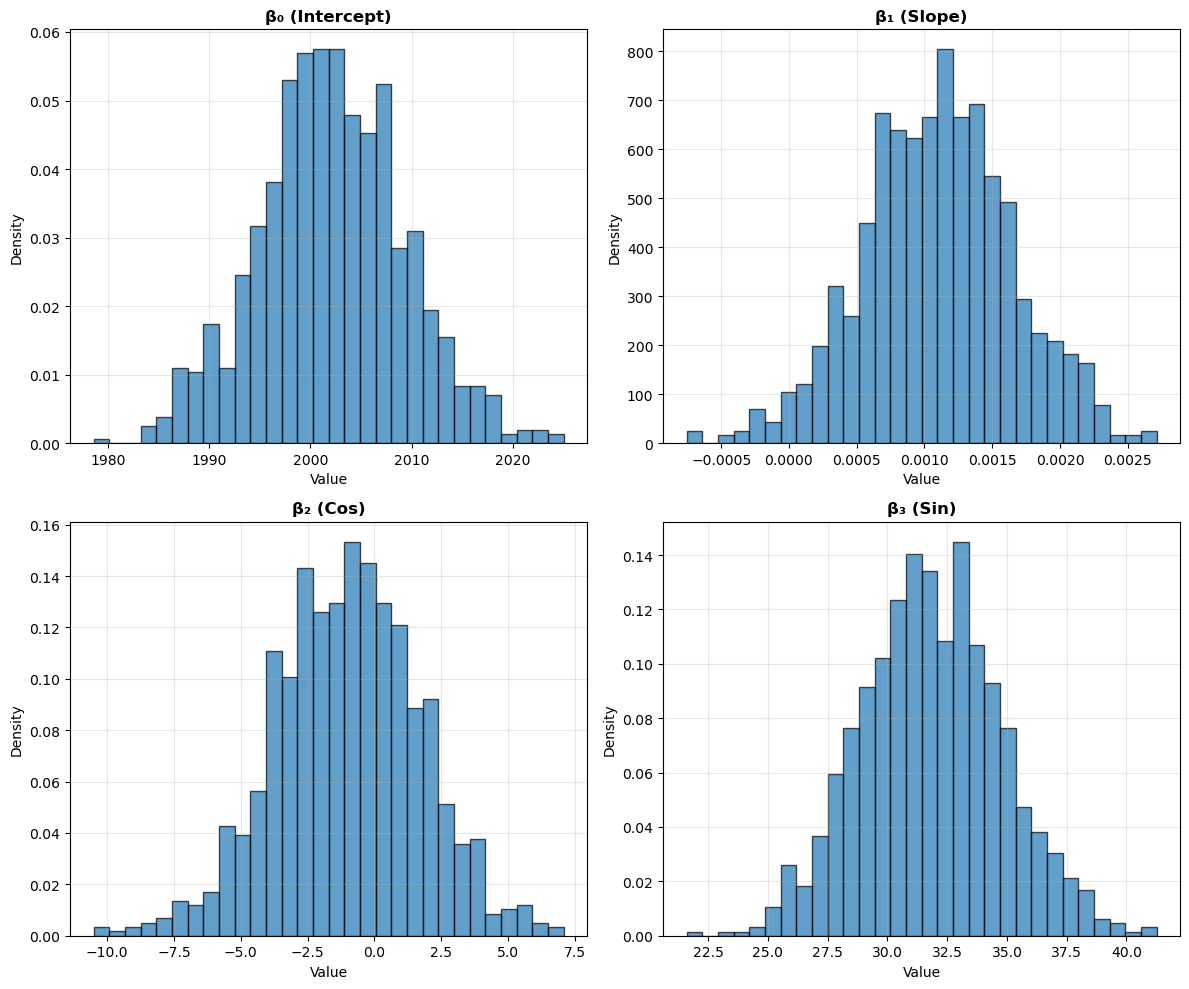

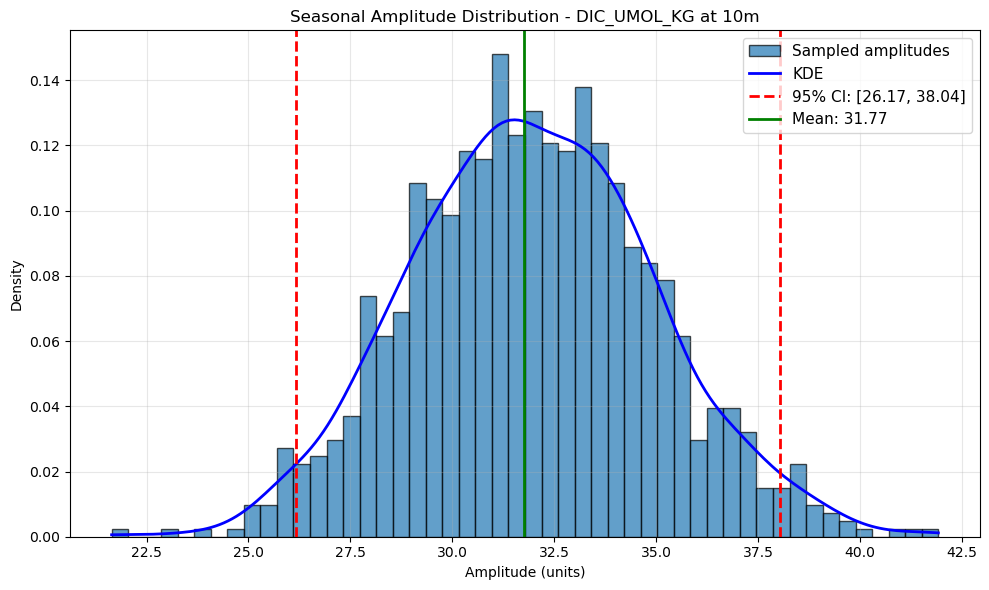

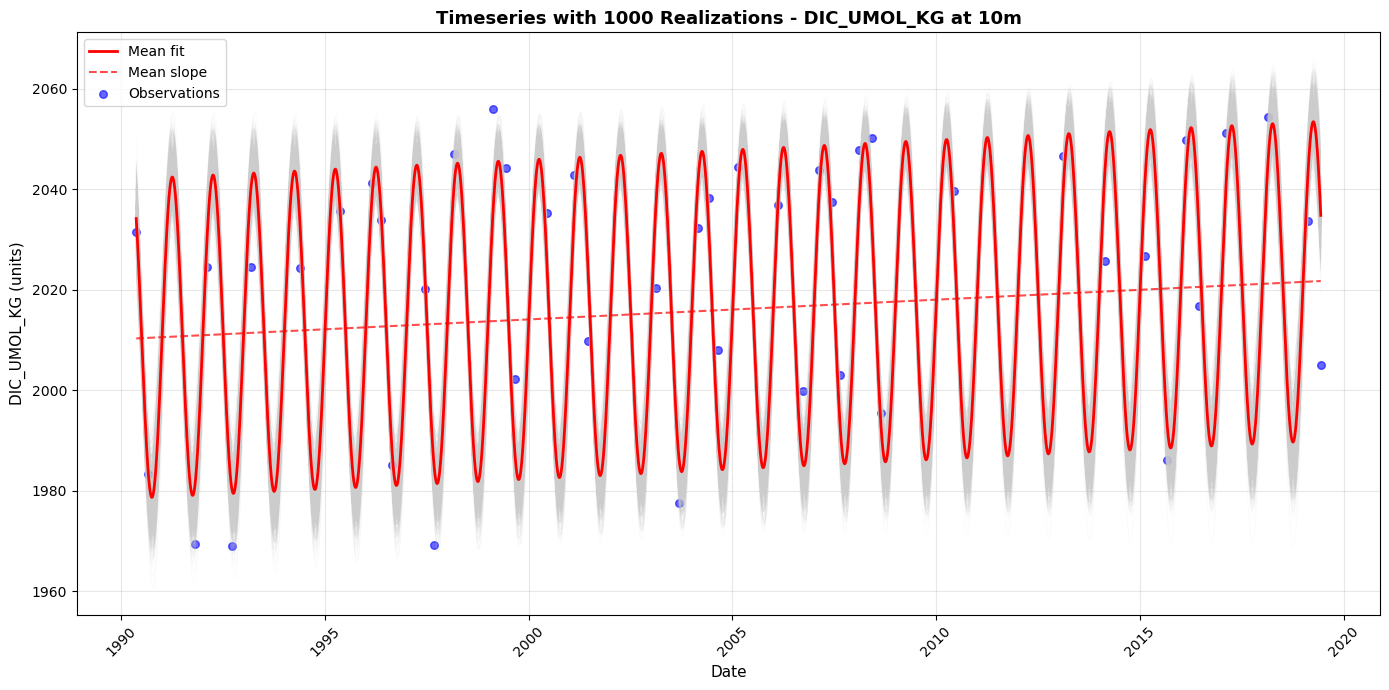


Analysis complete!


In [ ]:
# ============================================================================
# === Plotting ===
# ============================================================================

for depth in layers:
    if depth not in results:
        continue

    res = results[depth]

    # --- Plot 1: Parameter distributions ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    titles = ['β₀ (Intercept)', 'β₁ (Slope)', 'β₂ (Cos)', 'β₃ (Sin)']

    for idx, (ax, title) in enumerate(zip(axes.flat, titles)):
        ax.hist(res['R_samples'][:, idx], bins=30, density=True, alpha=0.7, edgecolor='black')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'parameter_distributions_{var2plot}_P{major_st}_{depth}m.png', dpi=150)
    plt.show()

    # --- Plot 2: Amplitude distribution ---
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(res['sampled_amplitudes'], bins=50, density=True, alpha=0.7,
            edgecolor='black', label='Sampled amplitudes')

    # Add KDE
    kde = gaussian_kde(res['sampled_amplitudes'])
    x_range = np.linspace(res['sampled_amplitudes'].min(),
                          res['sampled_amplitudes'].max(), 200)
    ax.plot(x_range, kde(x_range), 'b-', linewidth=2, label='KDE')

    ax.axvline(q025, color='red', linestyle='--', linewidth=2, label=f'95% CI: [{q025:.2f}, {q975:.2f}]')
    ax.axvline(q975, color='red', linestyle='--', linewidth=2)
    ax.axvline(res['amplitude_mean'], color='green', linestyle='-', linewidth=2,
               label=f'Mean: {res["amplitude_mean"]:.2f}')

    ax.set_xlabel('Amplitude (units)')
    ax.set_ylabel('Density')
    ax.set_title(f'Seasonal Amplitude Distribution - {var2plot} at {depth}m')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'amplitude_distribution_{var2plot}_P{major_st}_{depth}m.png', dpi=150)
    plt.show()

    # --- Plot 3: Timeseries with 1000 realizations ---
    if plot_timeseries:
        fig, ax = plt.subplots(figsize=(14, 7))

        # Plot 1000 sample timeseries (faint)
        for r in range(min(1000, len(res['R_samples']))):
            yfit_tmp = (res['R_samples'][r, 0] +
                       res['R_samples'][r, 1] * res['tfit_days'] +
                       res['R_samples'][r, 2] * np.cos(2*np.pi*res['tfit_days']/365.25) +
                       res['R_samples'][r, 3] * np.sin(2*np.pi*res['tfit_days']/365.25))
            ax.plot(res['tfit_dates'], yfit_tmp, color=[0.8, 0.8, 0.8], alpha=0.1, linewidth=0.5)

        # Plot mean fit
        ax.plot(res['tfit_dates'], res['yfit'], 'r-', linewidth=2, label='Mean fit')

        # Plot mean slope
        ax.plot(res['tfit_dates'], res['mean_slope'], 'r--', linewidth=1.5, alpha=0.7, label='Mean slope')

        # Plot original data
        ax.scatter(res['tdata_dates'], res['ydata'], color='blue', s=30, alpha=0.6, label='Observations')

        ax.set_xlabel('Date', fontsize=11)
        ax.set_ylabel(f'{var2plot} (units)', fontsize=11)
        ax.set_title(f'Timeseries with 1000 Realizations - {var2plot} at {depth}m', fontsize=13, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)

        # Format x-axis dates
        import matplotlib.dates as mdates
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig(f'timeseries_{var2plot}_P{major_st}_{depth}m.png', dpi=150)
        plt.show()

print("\n" + "="*60)
print("Analysis complete!")
print("="*60)